# Análisis cualitativo y cuantitativo de los clicks realizados del 5 al 13 de Marzo de 2019

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
clicks = pd.read_csv("clicks.csv", dtype={"source_id":"int8", "advertiser_id":"int8"})

In [3]:
clicks.isnull().sum()

advertiser_id          0
action_id          26351
source_id              0
created                0
country_code           0
latitude               0
longitude              0
wifi_connection        0
carrier_id            11
trans_id               0
os_minor              12
agent_device       23108
os_major              12
specs_brand            0
brand              20116
timeToClick         3374
touchX              3340
touchY              3340
ref_type               0
ref_hash               0
dtype: int64

In [4]:
clicksPosition = clicks[["touchX", "touchY"]]
clicksPosition.head()

,touchX,touchY
0,0.905,0.078
1,NaN,NaN
2,0.946,0.473
3,0.035,0.431
4,0.054,0.423


In [5]:
clicksPosition = clicksPosition.dropna()

In [6]:
clicksPosition['touchY'].max()

16.6

In [7]:
from scipy.stats import gaussian_kde
xPosition = clicksPosition["touchX"].values
yPosition = clicksPosition["touchY"].values

xy = np.vstack([xPosition,yPosition])
z = gaussian_kde(xy)(xy)

## Densidad de clicks en la pantalla

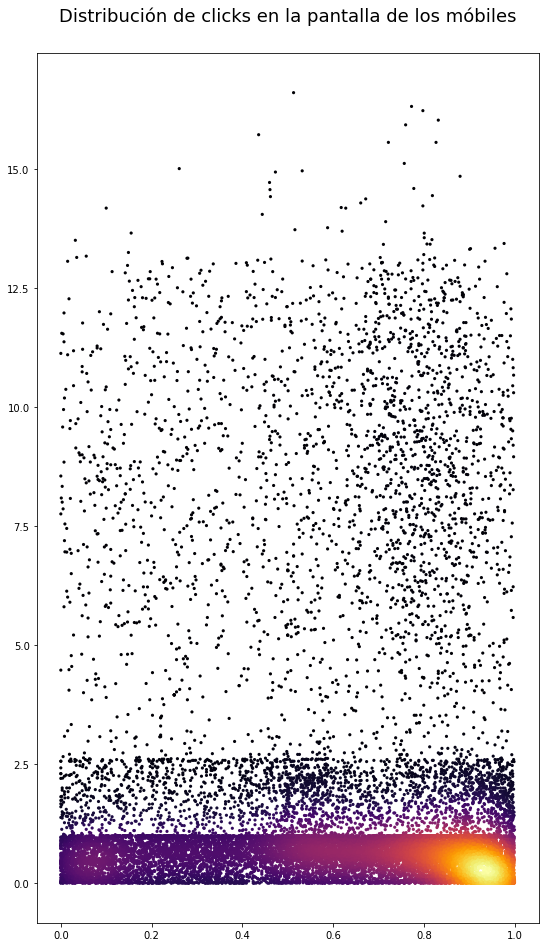

In [19]:
fig, ax = plt.subplots(figsize=(9, 16))
plt.title("Distribución de clicks en la pantalla de los móbiles", fontsize = 18)
ttl = ax.title
ttl.set_position([.5, 1.03])
ax.scatter(xPosition, yPosition, c=z, cmap="inferno", s=10, edgecolor="");

In [ ]:
plt.savefig("densidadClicks.png")

## ¿Cuánto tiempo tardan en clickear los usuarios sobre la publicidad?

In [ ]:
#Filtraremos los tiempos mayores a 60 segundos porque los consideramos errores en el dataset

In [59]:
clicks['timeToClick_aprox'] = clicks['timeToClick'].round(1)

In [60]:
times_filtered = clicks.loc[clicks['timeToClick_aprox'] <= 60, ["timeToClick_aprox"]]

In [61]:
times_filtered['time_count'] = 1
times_filtered_group = times_filtered.groupby('timeToClick_aprox').agg({'time_count':'count'})

Text(0.5, 0, 'Tiempo aproximado para clickear')

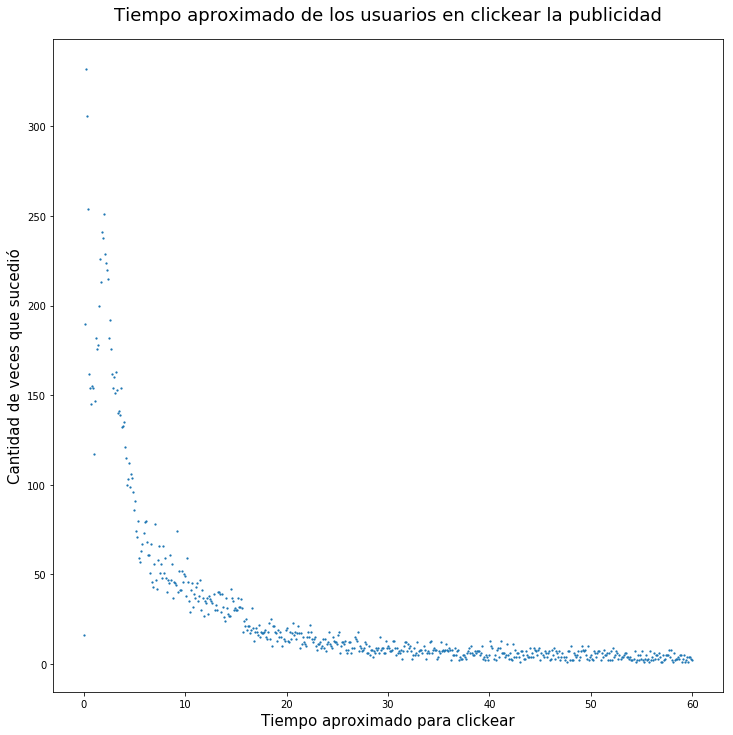

In [62]:
plot = times_filtered_group.reset_index().plot.scatter(x = 'timeToClick_aprox', y = 'time_count', s = 1.5, figsize = (12,12))

plot.set_title("Tiempo aproximado de los usuarios en clickear la publicidad", fontsize = 18)
plot.set_ylabel("Cantidad de veces que sucedió", fontsize = 15)
plot.title.set_position([.5, 1.02])
plot.set_xlabel("Tiempo aproximado para clickear", fontsize = 15)

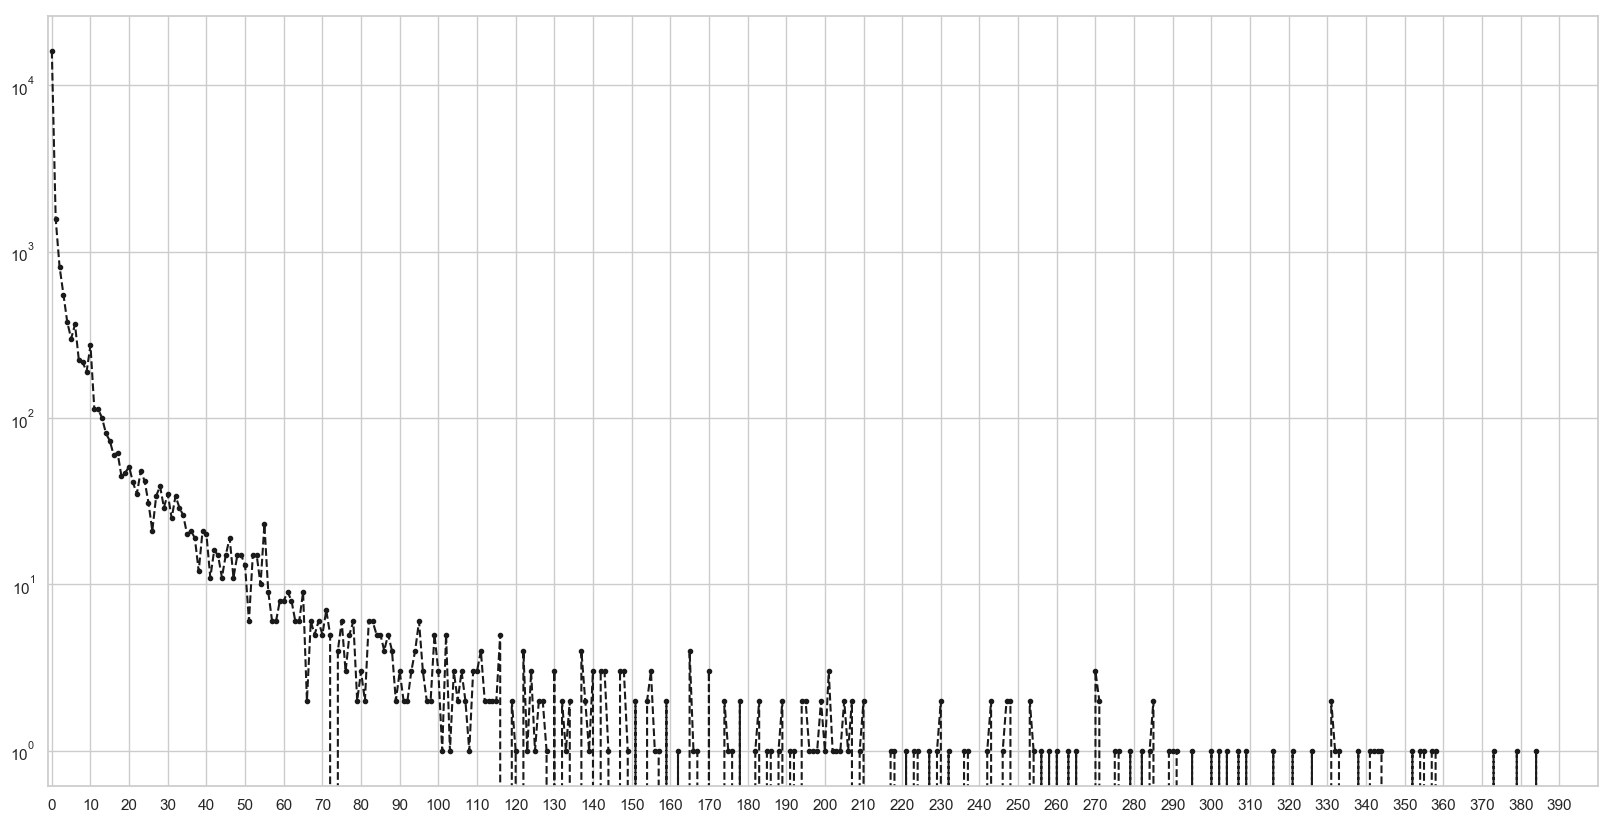

In [31]:
# Figure
fig, ax = plt.subplots(figsize=(20,10))

# Data
N = 400
m = max(time)/N
cantidad_time = []
for n in range(N):
    temp_var = time[np.where(time > n*m)]
    temp_var = temp_var[np.where(temp_var < (n + 1)*m)]
    cantidad_time.append(len(temp_var))

# Axes
ax.set_xticks(np.arange(0,N,10))
ax.set_xlim([-1,N])

# Plot
plt.plot(cantidad_time, "--.k")
plt.yscale("log")

## ¿Cómo fue la evolución de la cantidad de clicks según el tiempo que se tardó en clickear sobre la publicidad?

In [12]:
clicks_filtered = clicks.loc[clicks['timeToClick'] <= 60].copy()  #filtramos los timeToClick mayores a 60 segundos porque entendemos que carecen de lógica
clicks_filtered['timeToClick'] = clicks_filtered['timeToClick'].round(2)

In [13]:
clicks_filtered['cant_clicks'] = 1

In [17]:
timesToClick_grouped = clicks_filtered.groupby('timeToClick').agg({'cant_clicks': 'count'}).reset_index()

In [18]:
timesToClick_grouped = timesToClick_grouped.sort_values(by = 'timeToClick', ascending = True)

In [23]:
timesToClick_grouped['cant_clicks_acum'] = timesToClick_grouped['cant_clicks'].cumsum()

In [24]:
timesToClick_grouped.head(5)

,timeToClick,cant_clicks,cant_clicks_acum
0,0.02,1,1
1,0.03,4,5
2,0.04,5,10
3,0.05,7,17
4,0.06,8,25


Text(0.5, 0, 'Tiempo en segundos en clickear')

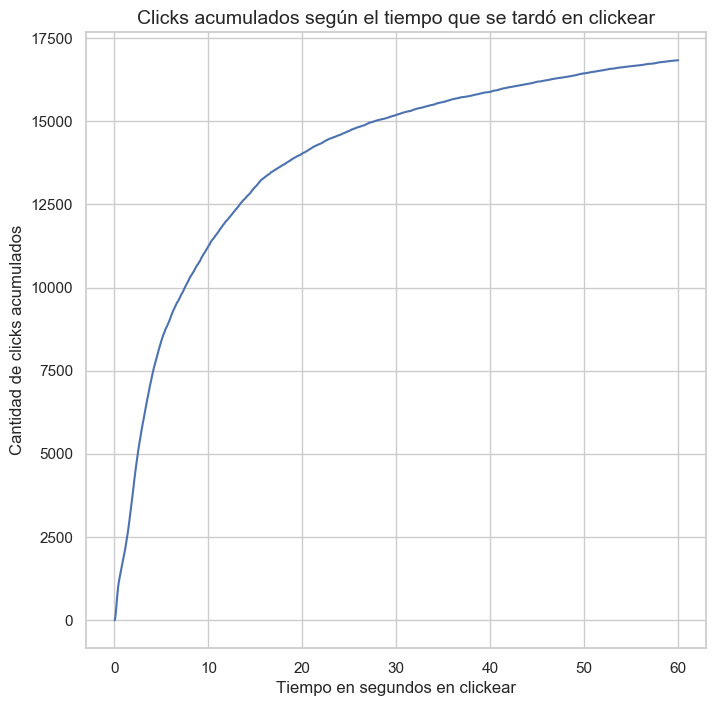

In [52]:
plot = timesToClick_grouped.plot.line(figsize = (8,8), x = 'timeToClick', y = 'cant_clicks_acum', linewidth = 1.5, legend = False)
plot.set_ylabel("Cantidad de clicks acumulados", fontsize = 12)
plot.set_title("Clicks acumulados según el tiempo que se tardó en clickear", fontsize = 14)
plot.set_xlabel("Tiempo en segundos en clickear", fontsize = 12)

## ¿Cuáles fueron los anunciantes -clientes de Jampp- que recibieron más clicks en sus publicidades?

In [25]:
clicks['cant_clicks'] = 1
group_advertisers = clicks.groupby('advertiser_id').agg({'cant_clicks': 'count'}).reset_index()

Text(0.5, 1.0, 'Cantidad de clicks registrados a cada anunciante')

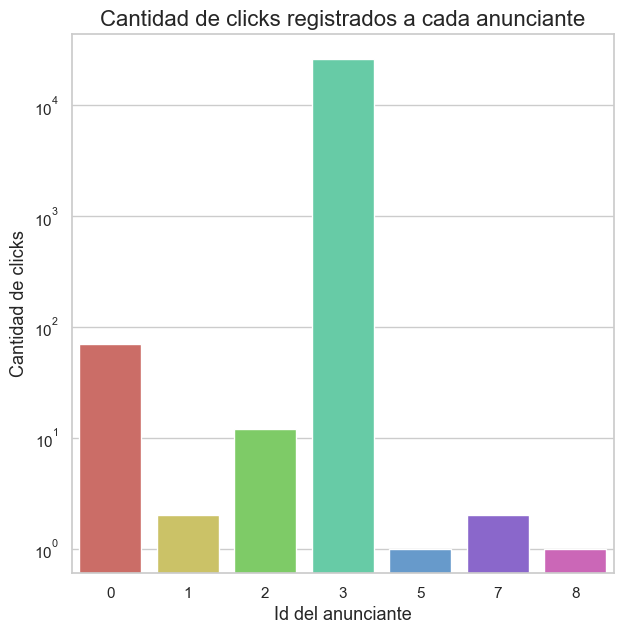

In [29]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (7, 7)

sns.set(style="whitegrid")

graph_clicks = sns.barplot(x= group_advertisers['advertiser_id'], y = group_advertisers['cant_clicks'], orient='v', palette="hls")
graph_clicks.set(yscale="log")
graph_clicks.set_xlabel("Id del anunciante", fontsize = 13)
graph_clicks.set_ylabel("Cantidad de clicks", fontsize = 13)
graph_clicks.set_title("Cantidad de clicks registrados a cada anunciante", fontsize = 16)

### ¿En qué horarios fue mayor el porcentaje de clicks con respecto a las subastas?

In [4]:
auctions_dtypes = {'auction_type_id': np.float16, 'country': 'category', 'platform': 'category',
                   'ref_type_id': 'category', 'source_id': 'category', 'device_id': 'category'}
auctions = pd.read_csv('auctions.csv', dtype = auctions_dtypes)

In [12]:
auctions["date"] =  pd.to_datetime(auctions["date"], errors = "coerce")
clicks["created"] = pd.to_datetime(clicks["created"], errors = "coerce")

In [13]:
auctions["hora"] = auctions["date"].dt.hour
clicks['hora'] = clicks['created'].dt.hour
clicks['click_count'] = 1
auctions["auction_count"] = 1

In [14]:
auc_x_hora = auctions.groupby(by="hora").agg({"auction_count":"count"})
clicks_x_hora = clicks.groupby(by="hora").agg({"click_count":"count"})

In [15]:
join_por_hora = auc_x_hora.join(clicks_x_hora)

In [16]:
join_por_hora["porcentaje"] =  join_por_hora["click_count"] * 100 / join_por_hora["auction_count"]

In [20]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (13, 10)

sns.set(style="whitegrid")

Text(0.5, 1.0, 'Porcentaje de clicks por hora en relación a la cantidad de subastas')

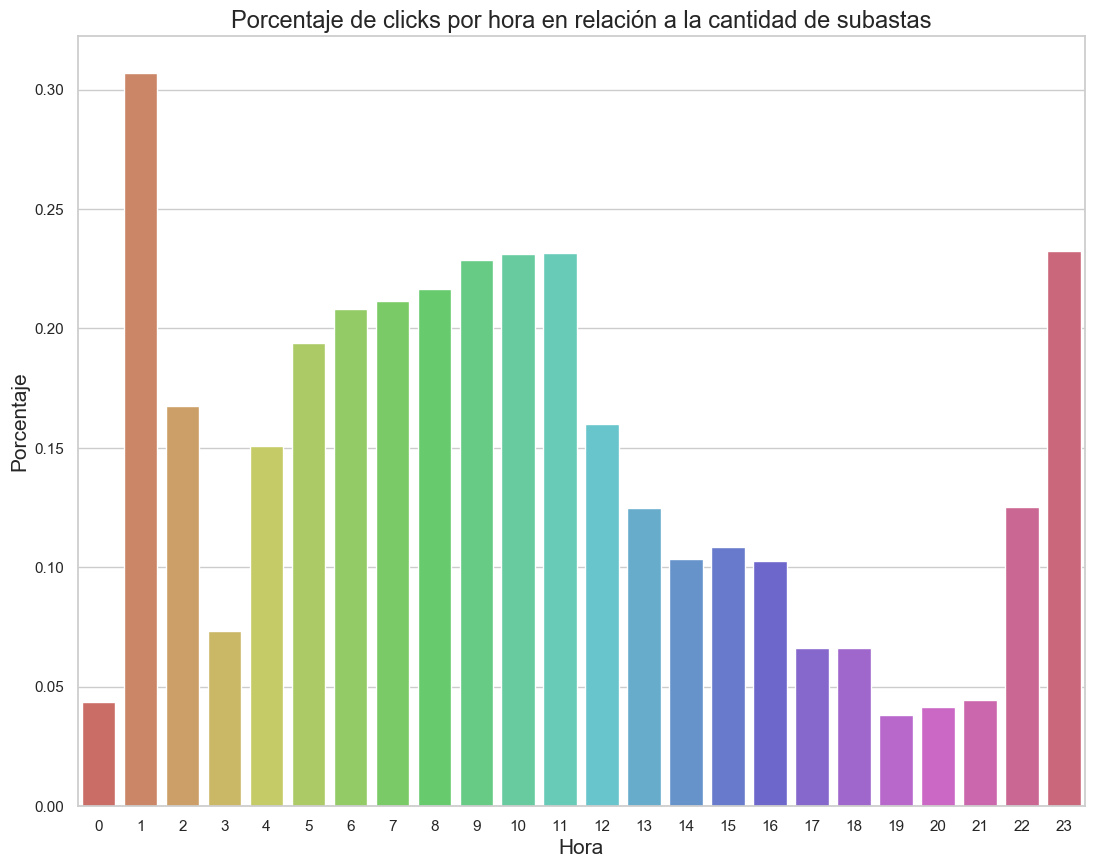

In [21]:
graph = sns.barplot(x= join_por_hora.reset_index()['hora'], y = join_por_hora['porcentaje'], orient='v', palette="hls")
graph.set_xlabel("Hora", fontsize = 15)
graph.set_ylabel("Porcentaje", fontsize = 15)
graph.set_title("Porcentaje de clicks por hora en relación a la cantidad de subastas", fontsize = 17)